# Grover's algorithm examples

This notebook has examples demonstrating how to use the Qiskit Algorithms [Grover](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.Grover.html) search algorithm, with different oracles.

<div class="alert alert-block alert-warning">
We strongly recommend to run this tutorial using Qiskit 2.0 or newer. Though the use of `PhaseOracle` is possible in Qiskit < 2.0, it requires the `tweedledum` library, which has been deprecated for a long time and isn't compatible with the most recent versions of Python.

This tutorial instead use the more recent `PhaseOracleGate` that has been introduced in Qiskit 2.1. Note that both are valid inputs for the `oracle` argument  of the `Grover` class.
</div>

## Finding solutions to 3-SAT problems

Let's look at an example 3-Satisfiability (3-SAT) problem and walk-through how we can use Quantum Search to find its satisfying solutions. 3-SAT problems are usually expressed in [Conjunctive Normal Forms (CNF)](https://en.wikipedia.org/wiki/Conjunctive_normal_form) and written in the [DIMACS-CNF](http://www.satcompetition.org/2009/format-benchmarks2009.html) format. For example:

In [1]:
input_3sat_instance = """
c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
"""

The CNF of this 3-SAT instance contains 3 variables and 5 clauses:

$(\neg v_1 \vee \neg v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee v_3) \wedge (v_1 \vee v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee \neg v_3) \wedge (\neg v_1 \vee v_2 \vee v_3)$

It can be verified that this 3-SAT problem instance has three satisfying solutions:

$(v_1, v_2, v_3) = (T, F, T)$ or $(F, F, F)$ or $(T, T, F)$

Or, expressed using the DIMACS notation:

`1 -2 3`, or `-1 -2 -3`, or `1 2 -3`.

With this example problem input, we then create the corresponding `oracle` for our `Grover` search. In particular, we use the `PhaseOracle` component, which supports parsing DIMACS-CNF format strings and constructing the corresponding oracle circuit. Note that the `PhaseOracle` requires the `tweedledum` library if you use Qiskit in a lower version than `2.0`.

In [2]:
from qiskit.exceptions import MissingOptionalLibraryError
from qiskit.circuit.library.phase_oracle import PhaseOracleGate
from qiskit.synthesis.boolean.boolean_expression import BooleanExpression

oracle = None
try:
    oracle = PhaseOracleGate(BooleanExpression.from_dimacs(input_3sat_instance).expression)
except ImportError as ex:
    print(ex)

The `oracle` can now be used to create a `Grover` instance:

In [3]:
from qiskit_algorithms import AmplificationProblem

problem = None
if oracle is not None:
    problem = AmplificationProblem(oracle)

We can then configure the backend and run the Grover instance to get the result:

In [4]:
from qiskit_algorithms import Grover
from qiskit.primitives import StatevectorSampler

grover = Grover(sampler=StatevectorSampler())
result = None
if problem is not None:
    result = grover.amplify(problem)
    print(result.assignment)

101


As seen above, a satisfying solution to the specified 3-SAT problem is obtained. And it is indeed one of the three satisfying solutions.

Since we used the `StatevectorSampler`, the complete measurement result is also returned, as shown in the plot below, where it can be seen that the binary strings `000`, `011`, and `101` (note the bit order in each string), corresponding to the three satisfying solutions all have high probabilities associated with them.

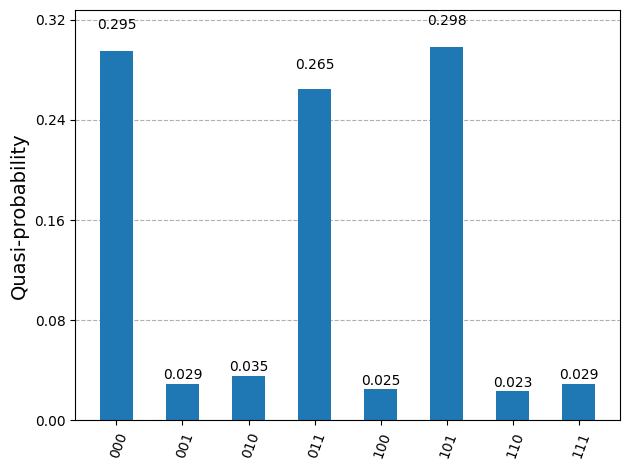

In [5]:
from qiskit.visualization import plot_histogram

if result is not None:
    display(plot_histogram(result.circuit_results[0]))

## Boolean Logical Expressions

Qiskit's `Grover` can also be used to perform Quantum Search on an `Oracle` constructed from other means, in addition to DIMACS. For example, the `PhaseOracle` can actually be configured using arbitrary Boolean logical expressions, as demonstrated below.

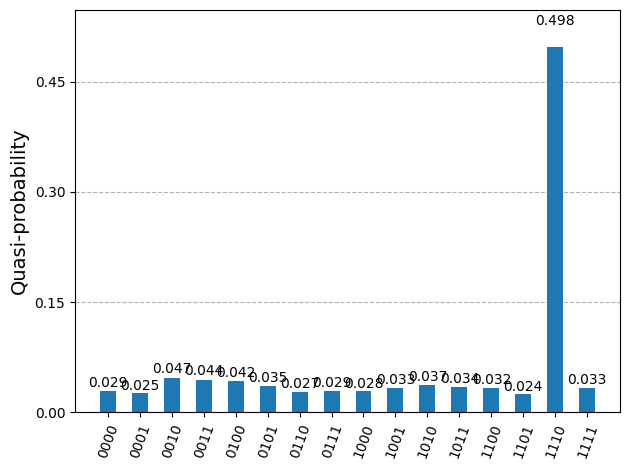

In [6]:
expression = "(w ^ x) & ~(y ^ z) & (x & y & z)"
try:
    oracle = PhaseOracleGate(expression)
    problem = AmplificationProblem(oracle)
    grover = Grover(sampler=StatevectorSampler())
    result = grover.amplify(problem)
    display(plot_histogram(result.circuit_results[0]))
except MissingOptionalLibraryError as ex:
    print(ex)

In the example above, the input Boolean logical expression `'(w ^ x) & ~(y ^ z) & (x & y & z)'` should be quite self-explanatory, where `^`, `~`, and `&` represent the Boolean logical XOR, NOT, and AND operators, respectively. It should be quite easy to figure out the satisfying solution by examining its parts: `w ^ x` calls for `w` and `x` taking different values; `~(y ^ z)` requires `y` and `z` be the same; `x & y & z` dictates all three to be `True`. Putting these together, we get the satisfying solution `(w, x, y, z) = (False, True, True, True)`, which our `Grover`'s result agrees with.

In [7]:
import tutorial_magics

%qiskit_version_table
%qiskit_copyright